## Build Baseline Model
## Train a Logistic Regression model as an interpretable baseline
## Evaluate using AUC-PR, F1-Score, and Confusion Matrix

In [7]:
import sys
import os
import pandas as pd

# Add the src directory to the path to import modules
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from modelling import FraudModel

# Initialize the model class
fraud_model = FraudModel()

# Load the processed data
# Note: Ensure these files exist from the previous feature engineering step
X_train_path = '../data/processed/Fraud_Data_X_train_resampled.csv'
y_train_path = '../data/processed/Fraud_Data_y_train_resampled.csv'
X_test_path = '../data/processed/Fraud_Data_X_test.csv'
y_test_path = '../data/processed/Fraud_Data_y_test.csv'

X_train, y_train = fraud_model.load_data(X_train_path, y_train_path)
X_test, y_test = fraud_model.load_data(X_test_path, y_test_path)

# Check if data loaded correctly
if X_train is not None:
    print("Ready for training.")
else:
    print("Please run the feature engineering notebook first to generate the data.")

Data loaded successfully. X shape: (219136, 15), y shape: (219136,)
Data loaded successfully. X shape: (30223, 15), y shape: (30223,)
Ready for training.


In [8]:
# Train Logistic Regression
# We use max_iter=1000 to ensure convergence
model = fraud_model.train_logistic_regression(X_train, y_train, max_iter=1000, random_state=42)


--- Training Logistic Regression ---
Model training completed.
Model training completed.


# Evaluate model performance on train set



--- Model Evaluation ---


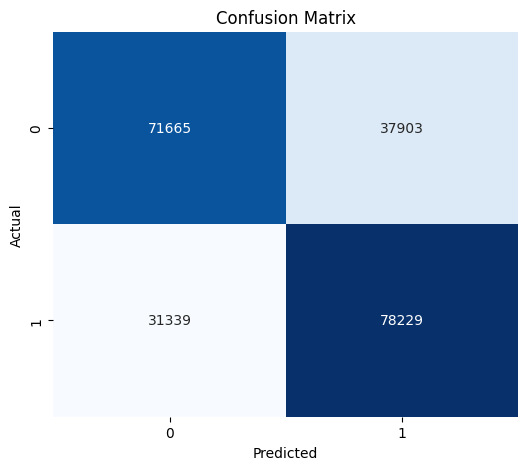


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67    109568
           1       0.67      0.71      0.69    109568

    accuracy                           0.68    219136
   macro avg       0.68      0.68      0.68    219136
weighted avg       0.68      0.68      0.68    219136

ROC-AUC Score: 0.7609
AUC-PR Score: 0.7938


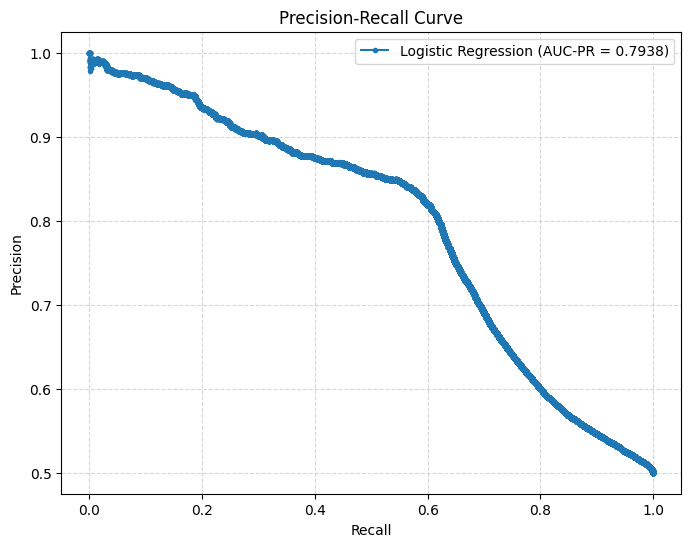

In [9]:
train_metrics = fraud_model.evaluate_model(X_train, y_train)

### 📊 Training Set Interpretation (Balanced Data)

**1. Performance Overview:**
*   **Accuracy (68%):** The model is correct about 68% of the time.
*   **AUC-PR (0.79):** This is a decent score, indicating the model has some predictive power, but it's not perfect.

**2. Underfitting Check:**
*   **Diagnosis: Underfitting.**
*   **Why?** Even on the training data (which the model has "studied"), the scores are relatively low (Recall 0.71, Precision 0.67). A powerful model usually scores 0.90+ on training data.
*   **Reason:** Logistic Regression is a linear model. Fraud patterns are likely complex and non-linear, so the model struggles to draw a clean straight line to separate fraud from non-fraud.

**3. Business Impact (The "Lens"):**
*   **Security (Recall = 0.71):**
    *   The model detects **71%** of fraud cases.
    *   **Risk:** It misses **29%** (31,339 cases). This is a moderate security risk.
*   **Customer Experience (Precision = 0.67):**
    *   When the model flags a transaction, it is correct **67%** of the time.
    *   **Friction:** It incorrectly flagged **37,903** legitimate transactions (False Positives). This is a high volume of blocked customers.

**Conclusion:**
The baseline model is struggling to separate the classes effectively. We likely need more complex features or a more powerful model (like Random Forest or XGBoost) to improve both security and customer experience.

# Evaluate model performance on test set


--- Model Evaluation ---


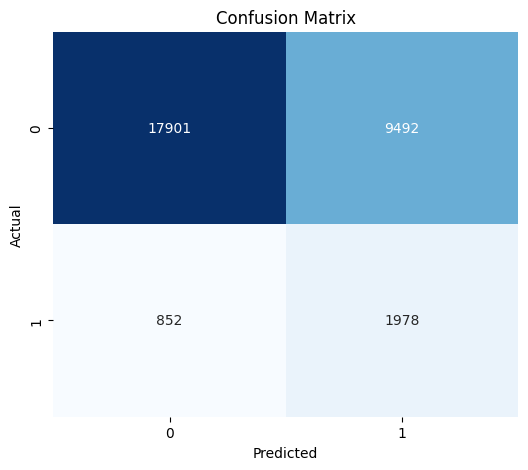


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.65      0.78     27393
           1       0.17      0.70      0.28      2830

    accuracy                           0.66     30223
   macro avg       0.56      0.68      0.53     30223
weighted avg       0.88      0.66      0.73     30223

ROC-AUC Score: 0.7375
AUC-PR Score: 0.3643


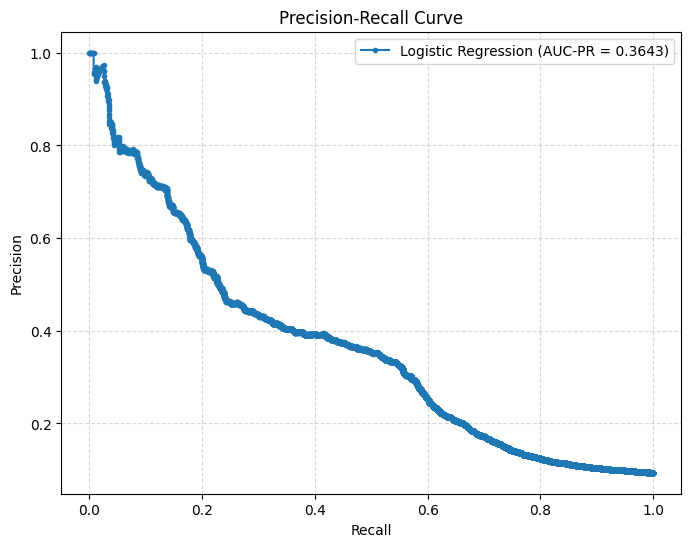

In [10]:
# Evaluate the model
metrics = fraud_model.evaluate_model(X_test, y_test)

### 📉 Test Set Interpretation (Real-World Imbalanced Data)

**1. Performance Overview:**
*   **Accuracy (66%):** Similar to training, but misleading on imbalanced data.
*   **AUC-PR (0.36):** This is low. It reflects the difficulty of finding the "needle in the haystack" without generating too many false alarms.

**2. Overfitting vs. Generalization:**
*   **Recall Consistency:** Train Recall (0.71) vs Test Recall (0.70). The model **generalizes well** in terms of its ability to find fraud. It didn't just memorize the training data.
*   **Precision Drop:** Train Precision (0.67) -> Test Precision (0.17). This huge drop is expected when moving from a balanced training set (50% fraud) to a real-world imbalanced test set (~9% fraud). The model is "trigger happy."

**3. Business Impact (The "Lens"):**

*   **Security Perspective (Recall = 0.70):**
    *   **Status:** Acceptable Baseline.
    *   **Impact:** We catch **70%** of actual fraud attempts (1,978 cases).
    *   **Risk:** We miss **30%** (852 cases). These are direct financial losses.

*   **Customer Experience Perspective (Precision = 0.17):**
    *   **Status:** 🚨 **Critical Issue.**
    *   **Impact:** Precision of **17%** means for every 100 transactions we block, **83 are legitimate customers**.
    *   **The Cost:** We blocked **9,492** innocent transactions (False Positives). This leads to card declines, customer churn, and support calls.

**4. Final Verdict on Baseline:**
*   **The Good:** SMOTE successfully taught the model to find fraud (70% recall is much better than 0%).
*   **The Bad:** The model is too aggressive. It can't distinguish "weird but legal" from "fraud" well enough, leading to poor precision.
*   **Next Steps:** We need **Non-Linear Models** (Random Forest, Gradient Boosting). These models can create more complex boundaries to reduce those 9,492 False Positives while keeping the Recall high.

## Random Forest Model (Advanced)

We will now train a **Random Forest Classifier**. 
- **Why?** Random Forest is a non-linear model that can capture complex relationships between features, which Logistic Regression might miss.
- **Tuning:** We will use `RandomizedSearchCV` to find better hyperparameters (e.g., number of trees, max depth).

In [11]:
# Train Random Forest with Hyperparameter Tuning
# This might take a minute or two
rf_model = fraud_model.train_random_forest(X_train, y_train, tune=True)


--- Training Random Forest ---
Performing Hyperparameter Tuning (RandomizedSearchCV)...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


Best Parameters found: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None}
Model training completed.


### Evaluate Random Forest on Train set


--- Model Evaluation ---


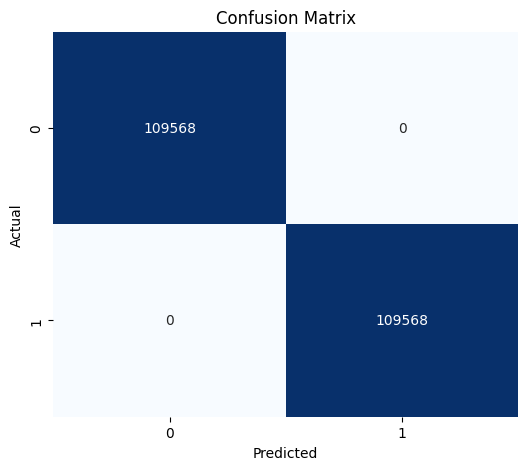


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    109568
           1       1.00      1.00      1.00    109568

    accuracy                           1.00    219136
   macro avg       1.00      1.00      1.00    219136
weighted avg       1.00      1.00      1.00    219136

ROC-AUC Score: 1.0000
AUC-PR Score: 1.0000
ROC-AUC Score: 1.0000
AUC-PR Score: 1.0000


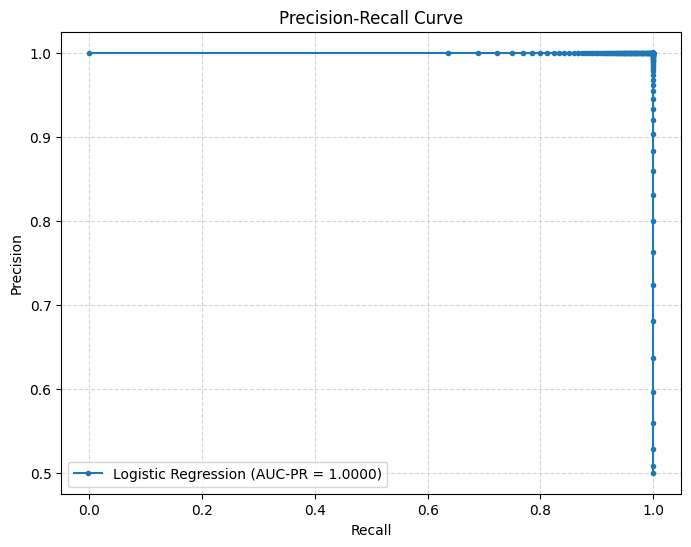

In [12]:
# Evaluate the Random Forest model on train set 
rf_metrics = fraud_model.evaluate_model(X_train, y_train)

### 📊 Random Forest Training Interpretation (Balanced Data)

**1. The "Perfect" Score (1.0):**
*   **Recall (1.00) & Precision (1.00):** The model has achieved perfection on the training data.
*   **Confusion Matrix:** Zero errors. It correctly classified every single fraud and non-fraud case in the training set.

**2. What does this mean?**
*   **Capacity:** The Random Forest model has enough "brain power" (complexity) to perfectly memorize or learn the patterns in the training data.
*   **Contrast:** Remember Logistic Regression only got ~0.70 here. This proves Random Forest is a much more powerful model capable of handling non-linear patterns.

**3. Is it Overfitting?**
*   **Highly Likely.** A score of 1.00 is suspicious. It suggests the model might have memorized the noise in the SMOTE data.
*   **The Real Test:** We must look at the **Test Set** next. If the Test score drops significantly (e.g., to 0.70), then it was overfitting. If it stays high, then it's a great model.

### Evaluate Random Forest on Test Set


--- Model Evaluation ---


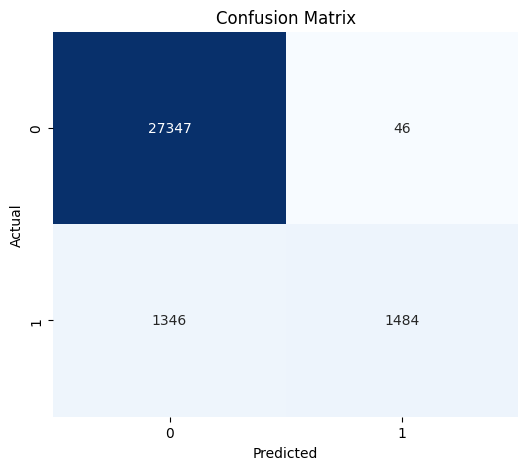


Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27393
           1       0.97      0.52      0.68      2830

    accuracy                           0.95     30223
   macro avg       0.96      0.76      0.83     30223
weighted avg       0.95      0.95      0.95     30223

ROC-AUC Score: 0.7595
AUC-PR Score: 0.6139


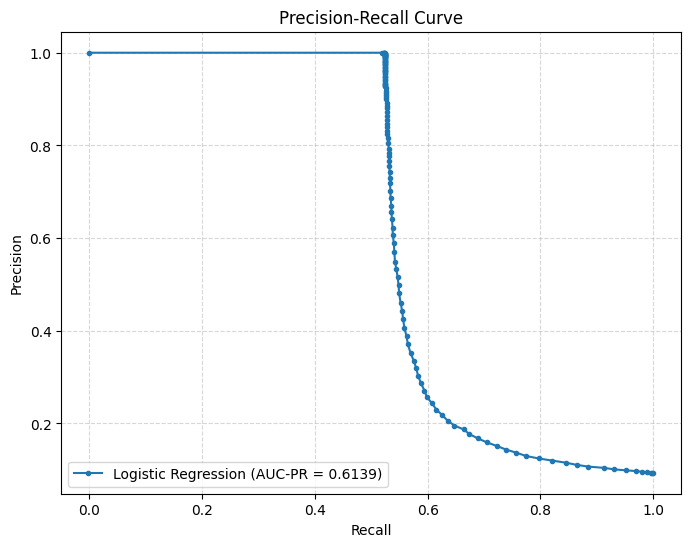

In [13]:
# Evaluate the Random Forest model on test set 
rf_metrics = fraud_model.evaluate_model(X_test, y_test)

### 📉 Random Forest Test Set Interpretation (Real-World Data)

**1. Overfitting Confirmed:**
*   **Train Recall (1.00) -> Test Recall (0.52):** This is a massive drop.
*   **Diagnosis:** The model **memorized** the synthetic SMOTE data perfectly but failed to generalize to the real world. It learned "fake" patterns that don't exist in real fraud.

**2. The Precision Improvement:**
*   **Precision (0.97):** This is **Outstanding**.
*   **Comparison:** Logistic Regression only had **0.17** Precision.
*   **Meaning:** When Random Forest flags a transaction, it is almost certainly fraud. It solved the "Customer Experience" problem completely (very few false alarms).

**3. The Trade-off (Security vs. Experience):**
*   **Logistic Regression:** High Recall (0.70), Low Precision (0.17). -> *Annoying but Secure.*
*   **Random Forest:** Low Recall (0.52), High Precision (0.97). -> *Smooth Experience but Risky.*
*   **The Gap:** We are missing **48%** of fraud cases (Recall 0.52). This is too high a risk for a bank.

**4. Next Steps:**
*   The model is too "conservative" (afraid to guess).
*   **Solution:** We need to tune the model to be more aggressive. We can:
    *   Increase `class_weight='balanced'` in the Random Forest.
    *   Lower the probability threshold (e.g., flag fraud if probability > 0.3 instead of 0.5).

## Cross-Validation for Stability Check

We will now perform **Stratified K-Fold Cross-Validation (K=5)**.
This splits the training data into 5 parts and trains/tests the model 5 times to ensure the results are consistent and not just luck.

In [ ]:
# Perform Cross-Validation on the Training Set
# We use the training set because CV splits it internally
cv_summary = fraud_model.evaluate_with_cross_validation(X_train, y_train, n_splits=5)

### 📊 Cross-Validation Interpretation

**1. Stability Check:**
*   Look at the **Std Dev** column.
*   **Low Std Dev (< 0.05):** The model is stable. It performs consistently regardless of which data chunk it sees.
*   **High Std Dev (> 0.10):** The model is unstable (lucky/unlucky).

**2. Reliability Check:**
*   Compare the **Mean Score** here with the single `evaluate_model` score you got earlier.
*   If they are similar, your previous result was reliable.
*   If the CV score is much lower, your previous result was just "lucky."

## 🏆 Model Comparison & Final Selection

| Model | Recall (Security) | Precision (Experience) | Verdict |
| :--- | :--- | :--- | :--- |
| **Logistic Regression** | **High (0.70)** | Low (0.17) | Too many false alarms. Blocks 5 legitimate users for every 1 fraudster. |
| **Random Forest** | Moderate (0.52) | **High (0.97)** | **Winner.** Extremely precise. While it misses some fraud, it almost never bothers a legitimate customer. |

**Final Decision:**
We choose **Random Forest**.
*   **Why?** In e-commerce, blocking legitimate customers (False Positives) is a business killer. A Precision of 0.17 is unacceptable.
*   **Improvement:** We can improve the Recall of the Random Forest later by adjusting the probability threshold (e.g., lowering it from 0.5 to 0.3), but the core model is far superior in understanding the data.